# Libraries

In [164]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from unidecode import unidecode

# Data Loading

In [165]:
csv_filename = "ARES2_EJECUCION_ACTIVIDADES.csv"
data = pd.read_csv(csv_filename)
print(data.head(10))

                                         DESCRIPCION CODIGO_ETAPA  \
0                                         Vacaciones          VAC   
1                                         Vacaciones          VAC   
2  Documentación proceso multipago bancario ajust...        COCOD   
3  Documentación proceso acumulación pisos y paso...        COCOD   
4  Documentación proceso acumulación pisos y cont...        COCOD   
5                                         Vacaciones          VAC   
6                                         Vacaciones          VAC   
7                                         Vacaciones          VAC   
8                                         Vacaciones          VAC   
9                                         Vacaciones          VAC   

   DURACION_HORAS  
0             8.0  
1             8.0  
2             3.0  
3             3.0  
4             2.0  
5             8.0  
6             8.0  
7             8.0  
8             8.0  
9             8.0  


# Data Cleaning

In [166]:
def get_all_characters() -> list:
    """
    @returns all the characters relevant for the model. Right now it is all the printable characters
    """
    all_characters: list = []
    # all_letters: list = list(string.ascii_letters)
    # all_digits = ["0","1","2","3","4","5","6","7","8","9"]
    printable_characters = list(string.printable)
    all_characters = printable_characters
    return all_characters


print(get_all_characters())


def get_column_labels():
    return {
        "CODIGO_ETAPA": "CODIGO_ETAPA",
        "DESCRIPCION": "DESCRIPCION",
        "DURACION_HORAS": "DURACION_HORAS",
    }
def get_all_stages(df: pd.DataFrame):
    res = df[get_column_labels()["CODIGO_ETAPA"]].unique() 
    return res
get_all_stages(data)


def get_relevant_columns_names() -> list:
    column_labels = get_column_labels()
    relevant_columns_names = [column_labels["CODIGO_ETAPA"], column_labels["DESCRIPCION"], column_labels["DURACION_HORAS"]]
    return relevant_columns_names


def get_clean_text(text: str) -> str:
    """
    @return string with only relevant characters to the model
    """
    all_characters = get_all_characters()
    text = unidecode(text)
    character_list = list(text)

    for char in character_list:
        if char not in all_characters:
            text = text.replace(char, "")
    return text


def get_relevant_columns(df: pd.DataFrame):
    rcn = get_relevant_columns_names()
    return df[rcn]


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ', '\t', '\n', '\r', '\x0b', '\x0c']


In [167]:
data = get_relevant_columns(data)
data[get_column_labels()['DESCRIPCION']] = data[get_column_labels()['DESCRIPCION']].apply(get_clean_text) 
print(data.head(10))

  CODIGO_ETAPA                                        DESCRIPCION  \
0          VAC                                         Vacaciones   
1          VAC                                         Vacaciones   
2        COCOD  Documentacion proceso multipago bancario ajust...   
3        COCOD  Documentacion proceso acumulacion pisos y paso...   
4        COCOD  Documentacion proceso acumulacion pisos y cont...   
5          VAC                                         Vacaciones   
6          VAC                                         Vacaciones   
7          VAC                                         Vacaciones   
8          VAC                                         Vacaciones   
9          VAC                                         Vacaciones   

   DURACION_HORAS  
0             8.0  
1             8.0  
2             3.0  
3             3.0  
4             2.0  
5             8.0  
6             8.0  
7             8.0  
8             8.0  
9             8.0  


# Model Creation for Stage Prediction

## Strings operations

In [168]:

def get_number_of_characters(s: str)->int:
    return len(s.replace(" ", ""))

def get_character_index(s: str)->int:
    all_characters: list = get_all_characters()
    index = all_characters.index(s)
    return index

## Biagram

In [169]:
# create matrix with biagram
def create_biagram() -> np.array:
    """
    @return a matrix filled with zeroes of size n_char x n_char
    """
    # The only characters we are going to consider.
    all_characters: list = get_all_characters()
    n_characters = len(all_characters)
    # create the matrix of size n_characters
    biagram: np.array = np.zeros((n_characters, n_characters))
    return biagram


def get_stage_descriptions(df: pd.DataFrame, stage: str) -> pd.DataFrame:
    """
    @input
        df: Dataframe with all the information.
        stage: stage to extract
    @return list with all the descriptions of the given stage
    """
    column_name: str = get_column_labels()["CODIGO_ETAPA"]
    mask = df[column_name] == stage
    return df[mask][get_column_labels()["DESCRIPCION"]]


def get_character_count(descriptions: pd.DataFrame) -> dict:
    """
    @input description: df with all the description of a stage.
    @return dictionary with character count of all the descriptions in a stage. 
    """
    all_characters = get_all_characters()
    character_count: dict = {}
    for description in descriptions:
        for character in all_characters:
            character_count[character] = description.count(character)
    return character_count


def get_filled_biagram(descriptions: pd.DataFrame) -> np.array:
    """
    @input list of all the descriptions for a stage
    @return matrix with character count, and the count of the next character
    """
    # create the matrix of size n_characters
    biagram: np.array = create_biagram()
    for description in descriptions:
        for index in range(0, len(description) - 1):
            # check current and next character
            current_character = description[index]
            current_character_index = get_character_index(current_character)

            next_character = description[index + 1]
            next_character_index = get_character_index(next_character)

            current_biagram_value = biagram[current_character_index][
                next_character_index
            ]
            biagram[current_character_index][next_character_index] = (
                current_biagram_value + 1
            )
    return biagram


## Probability Matrix

In [170]:
def normalize_probabilities(character_count: int, total_characters: int)->float:
    return character_count/total_characters

def get_marginal_probabilities(character_count: dict, text:str)->np.array:
    """
    @input 
        character_count: Dictionary with occurences of each character
        text: the text to analyse
    """
    character_probabilities = np.zeros(len(string.ascii_lowercase))
    n_characters = get_number_of_characters(text)
    for char in character_count.keys():
        index = list(character_count.keys()).index(char)
        character_probabilities[index] = normalize_probabilities(character_count[char], n_characters)+0.00001
    return character_probabilities

def get_cond_probabilities(joint_probability: np.array,marginal_probability: np.array)->np.array:
    conditional_probability = (joint_probability.T/marginal_probability).T
    # normalized matrix
    conditional_probability = conditional_probability/conditional_probability.sum() 
    prob_sum = conditional_probability.sum()
    print(f"prob_sum = {prob_sum}")
    return conditional_probability

def get_joint_probabilities(characters_count: np.array)->np.array:
    all_characters = get_all_characters()
    # + len(all_characters) to account for repetitions (aa, bb, cc, dd, etc.)
    n_pairs = characters_count.sum()
    joint_probability_matrix = create_biagram()
    prob_sum = 0
    for i, row in enumerate(characters_count):
        for j,count in enumerate(characters_count):
            joint_probability_matrix[i][j] = normalize_probabilities(characters_count[i][j], n_pairs)
            prob_sum = prob_sum + joint_probability_matrix[i][j]
    print(f"prob_sum = {prob_sum}")
    return joint_probability_matrix

In [171]:
def graph_matrix_heatmap(matrix: np.array, title="Heatmap"):
    all_characters = get_all_characters()
    # fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(matrix, cmap="Blues" ,annot=False, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()

## Model Creation

# Model implementation for Stage prediction

## COCOD

### Descriptions

In [172]:

cocod_descriptions = get_stage_descriptions(data, "COCOD")
print(cocod_descriptions.head(10))

2     Documentacion proceso multipago bancario ajust...
3     Documentacion proceso acumulacion pisos y paso...
4     Documentacion proceso acumulacion pisos y cont...
21    Implementacion de proceso de curaduria y cambi...
23       Revision de reporte de cuentas administrativas
24       Revision de reporte de cuentas administrativas
25       Revision de reporte de cuentas administrativas
26                              daily, modales interfaz
27                                 modales herramientas
28                                 modales herramientas
Name: DESCRIPCION, dtype: object


prob_sum = 1.000000000000017


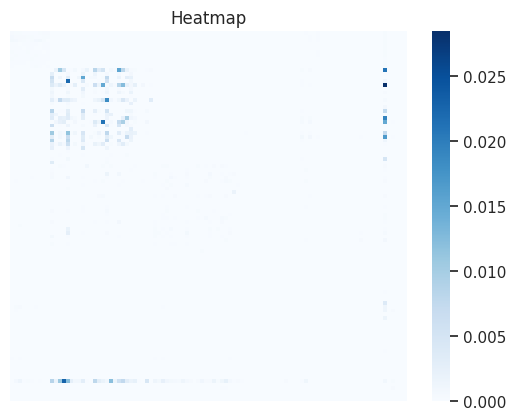

In [173]:
COCOD_dist = get_filled_biagram(cocod_descriptions)
COCOD_dist = get_joint_probabilities(COCOD_dist)
graph_matrix_heatmap(COCOD_dist)


### Random Testing

prob_sum = 0.9999999999999996


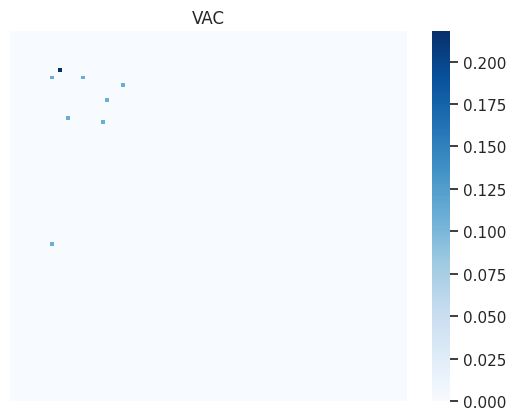

prob_sum = 1.000000000000017


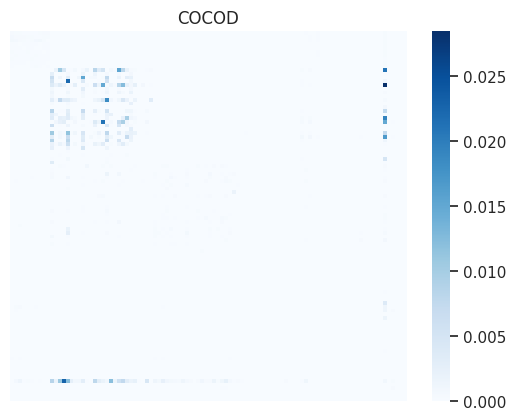

prob_sum = 0.999999999999995


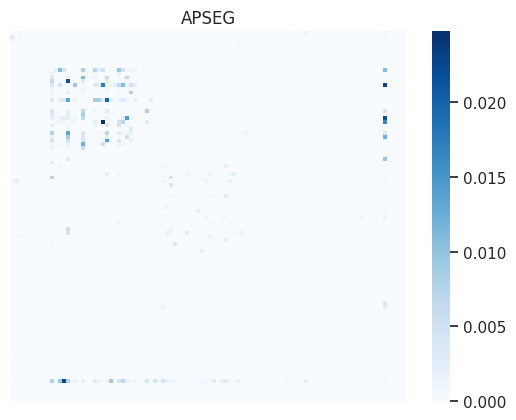

prob_sum = 1.0000000000000002


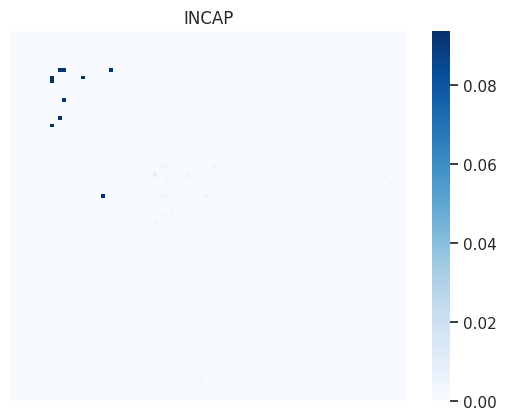

prob_sum = 0.9999999999999967


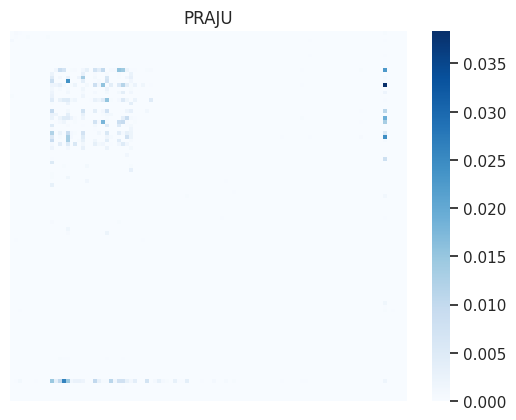

prob_sum = 0.9999999999999949


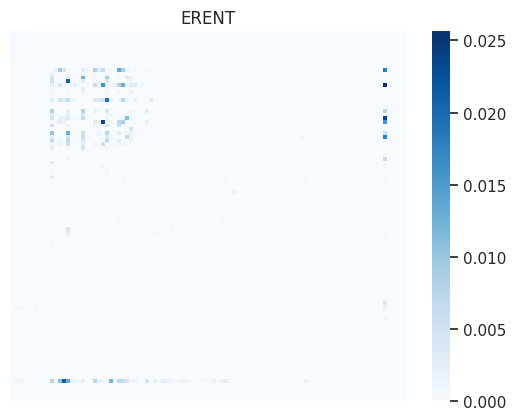

prob_sum = 1.0000000000000009


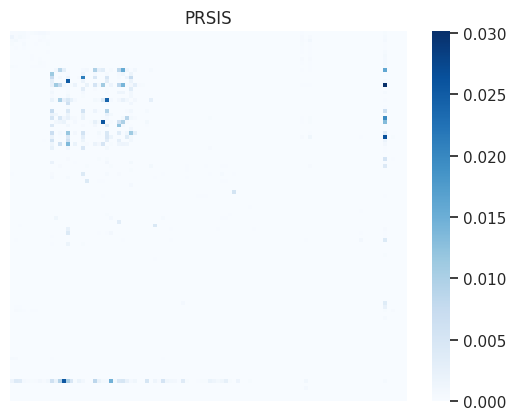

prob_sum = 1.0000000000000067


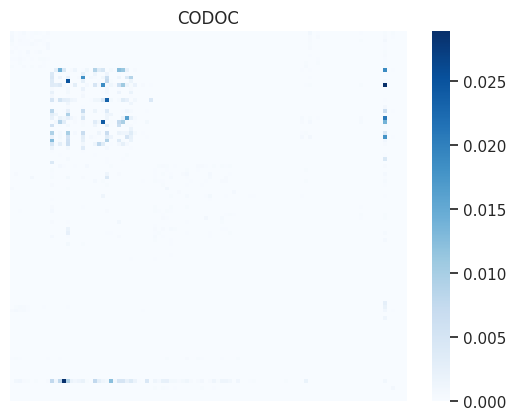

prob_sum = 0.9999999999999944


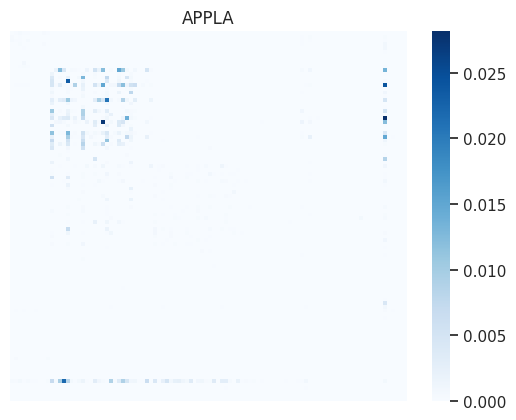

prob_sum = 1.0000000000000022


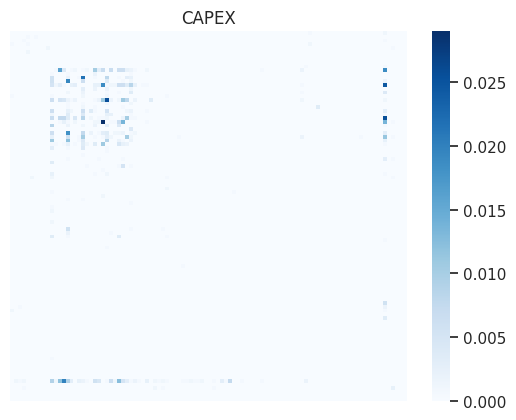

prob_sum = 1.0000000000000107


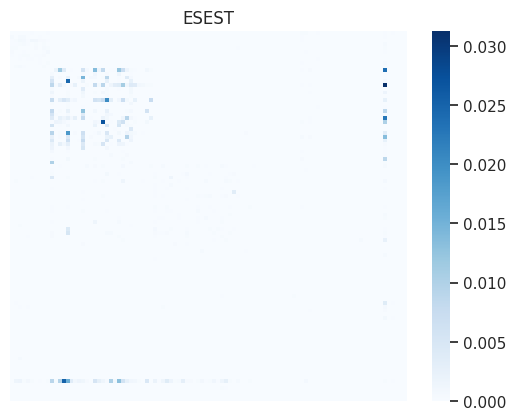

prob_sum = 0.9999999999999885


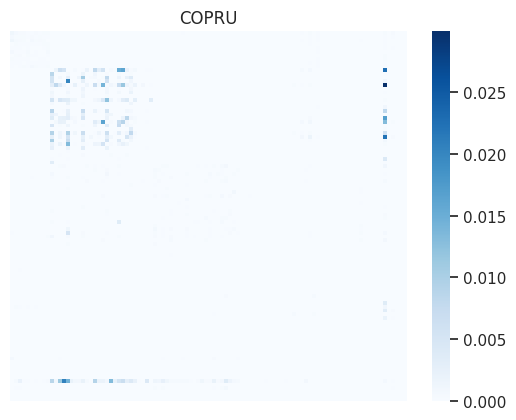

prob_sum = 0.9999999999999921


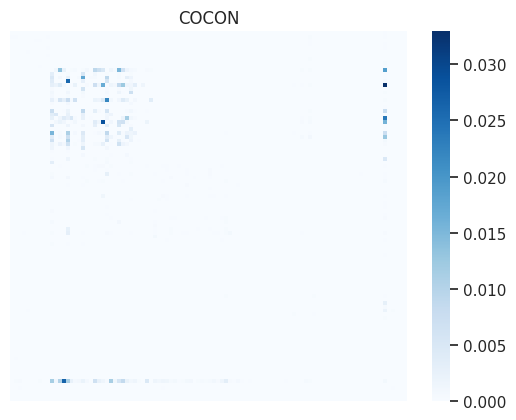

prob_sum = 0.9999999999999926


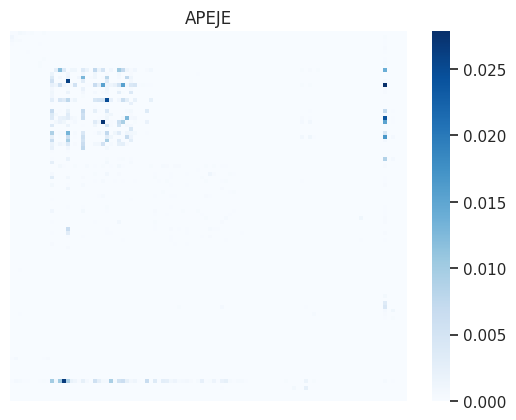

prob_sum = 0.9999999999999968


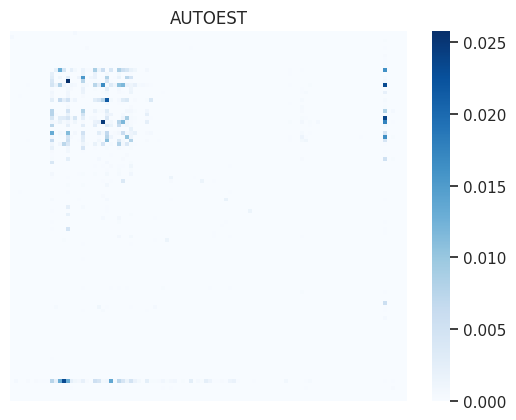

prob_sum = 0.999999999999993


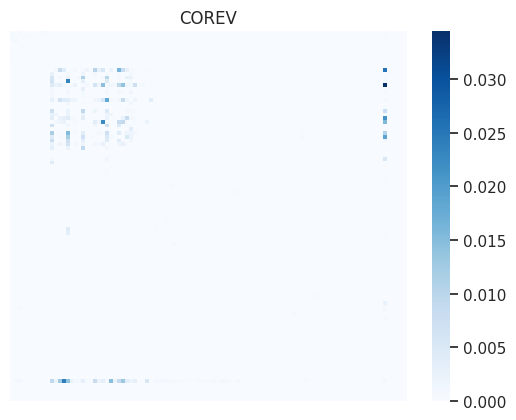

prob_sum = 0.9999999999999967


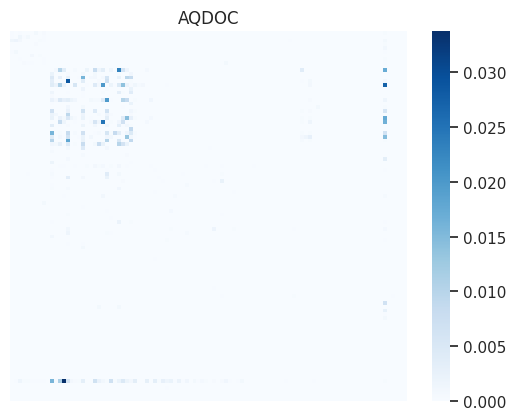

prob_sum = 1.000000000000004


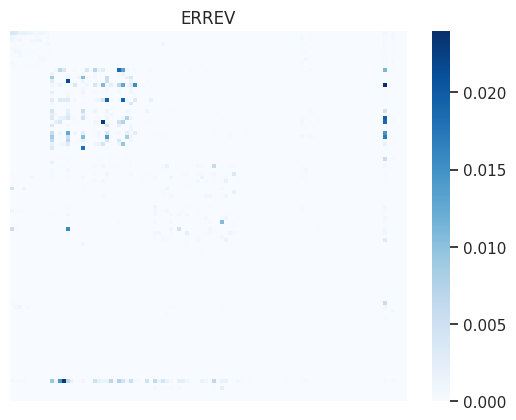

prob_sum = 0.999999999999998


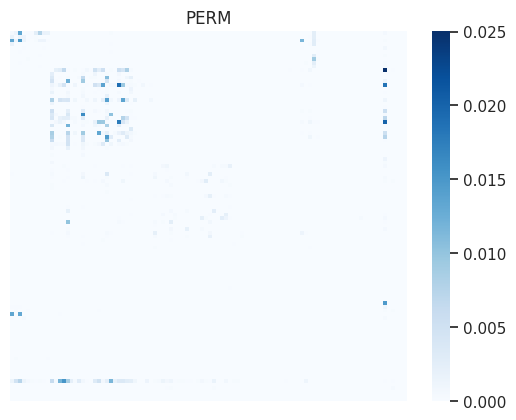

prob_sum = 0.9999999999999993


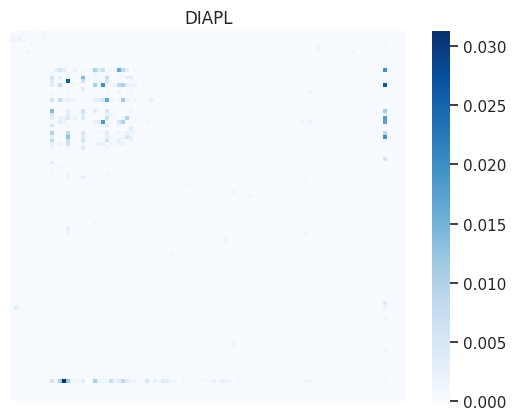

prob_sum = 0.9999999999999898


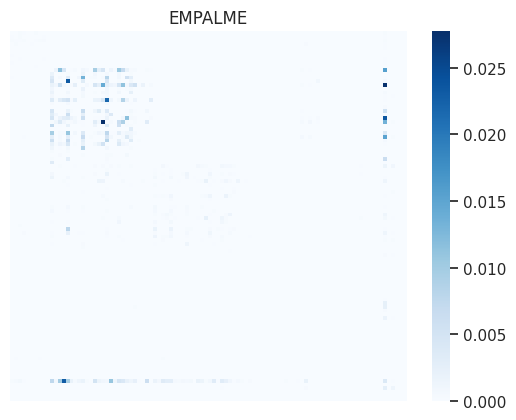

prob_sum = 0.9999999999999973


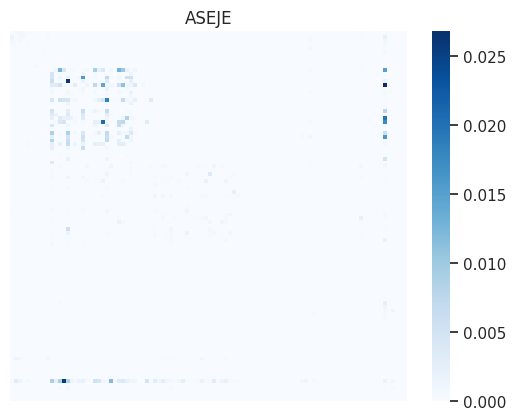

prob_sum = 0.9999999999999968


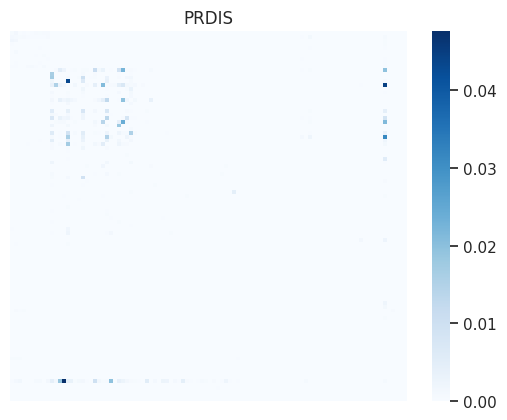

prob_sum = 0.99999999999999


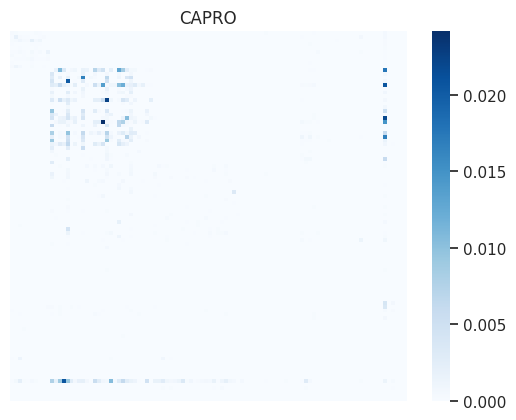

prob_sum = 0.9999999999999968


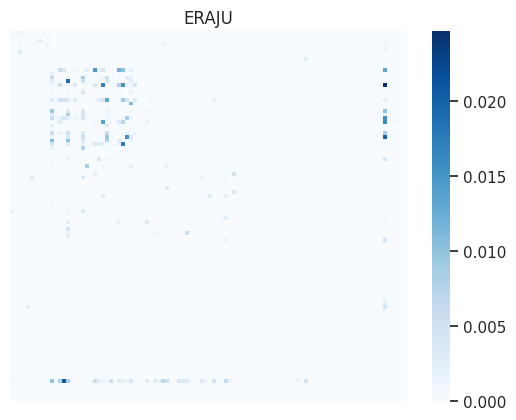

prob_sum = 0.9999999999999942


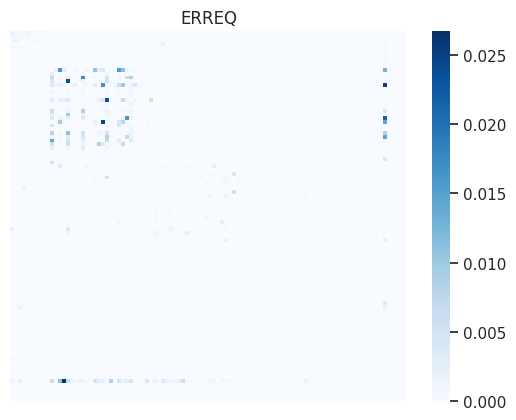

prob_sum = 0.9999999999999957


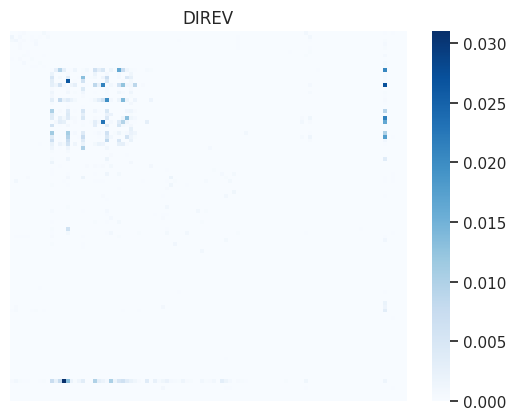

prob_sum = 0.9999999999999953


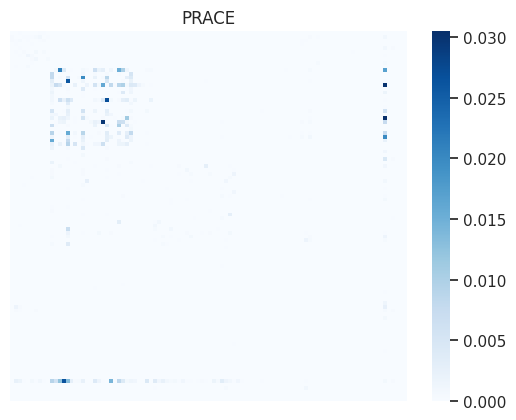

prob_sum = 1.0000000000000075


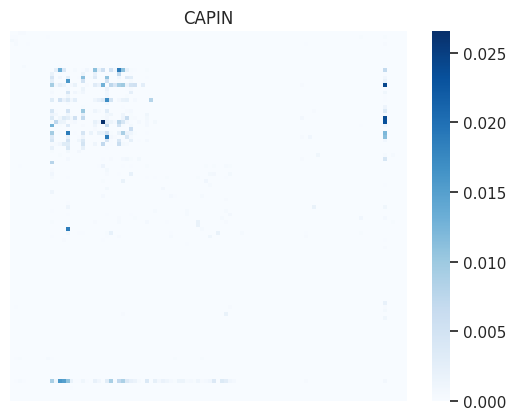

prob_sum = 1.0000000000000049


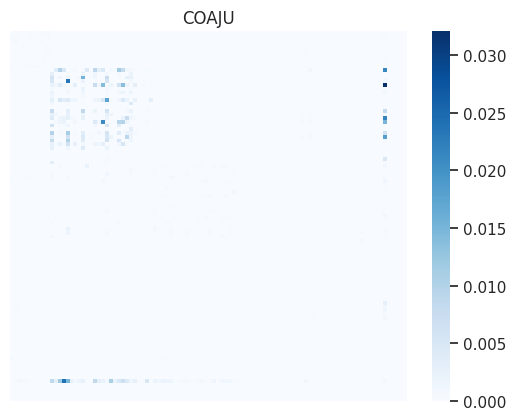

prob_sum = 1.0000000000000064


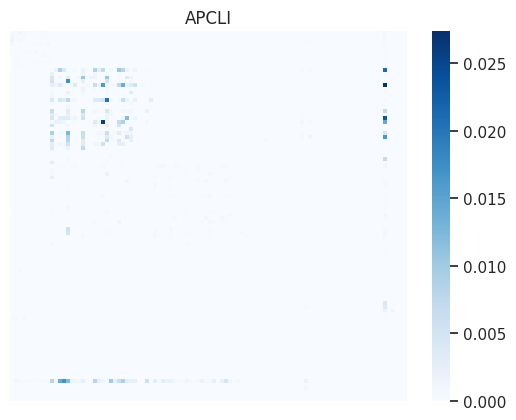

prob_sum = 0.9999999999999966


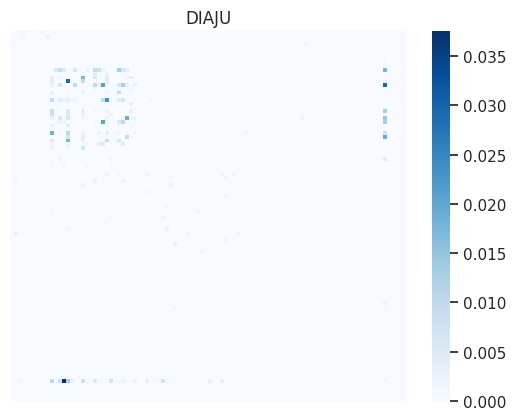

prob_sum = 0.9999999999999946


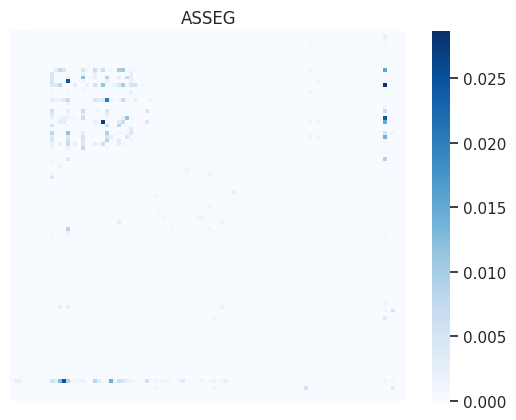

prob_sum = 0.9999999999999949


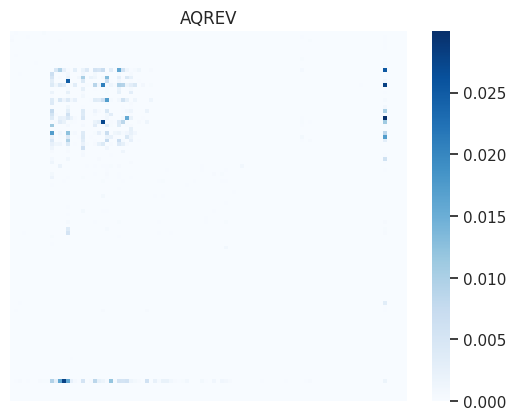

prob_sum = 1.0000000000000007


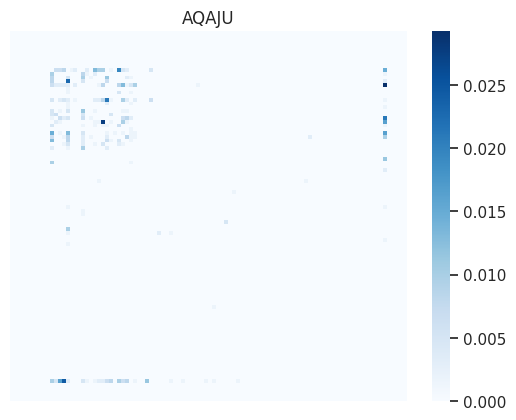

prob_sum = 1.0000000000000022


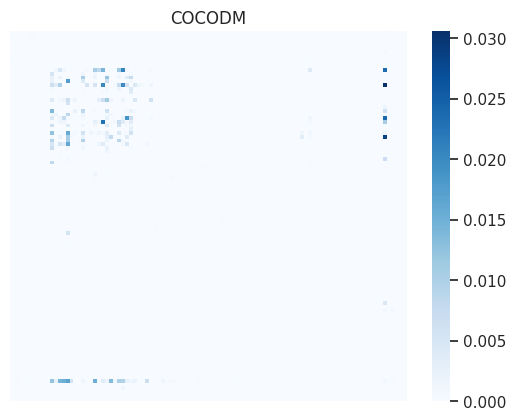

prob_sum = 1.0000000000000047


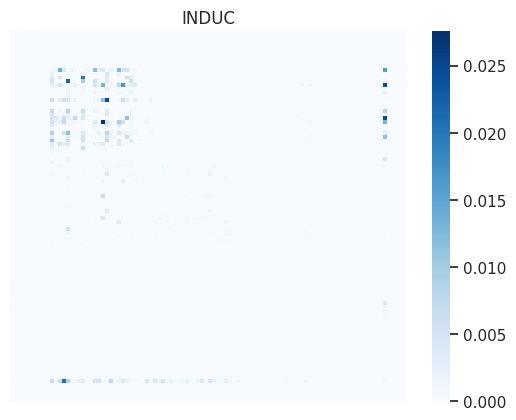

prob_sum = 1.0000000000000022


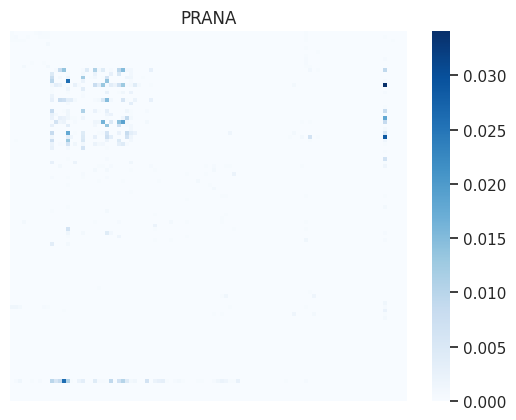

prob_sum = 1.0000000000000075


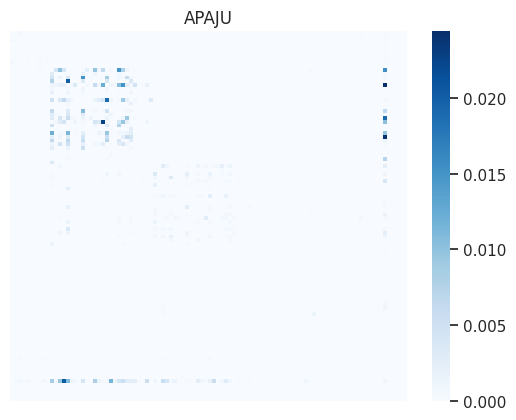

prob_sum = 0.9999999999999963


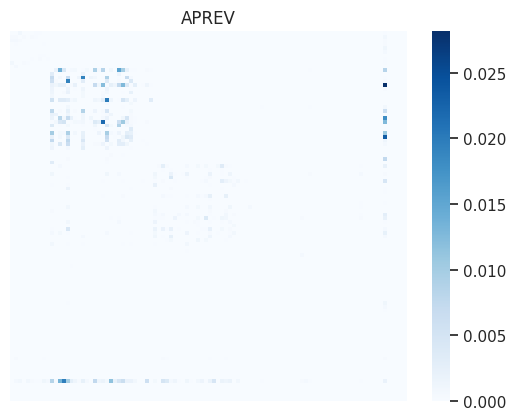

prob_sum = 1.0000000000000016


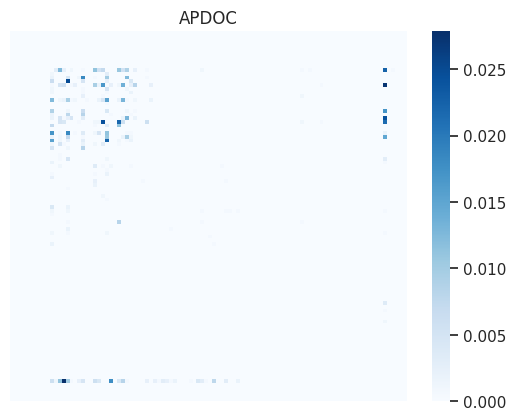

prob_sum = 0.9999999999999939


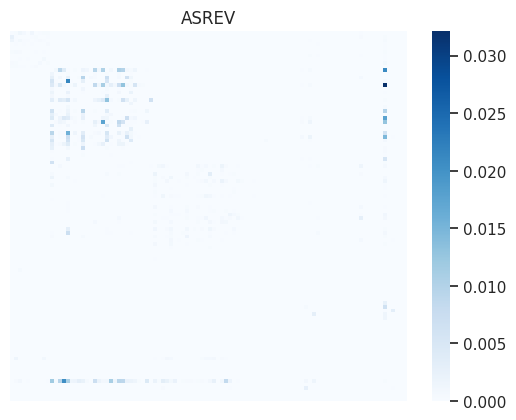

prob_sum = 1.0000000000000067


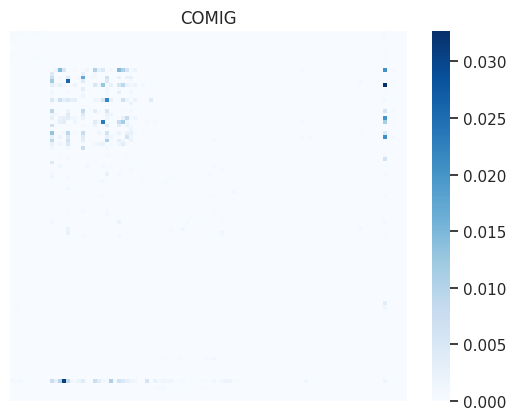

prob_sum = 0.9999999999999973


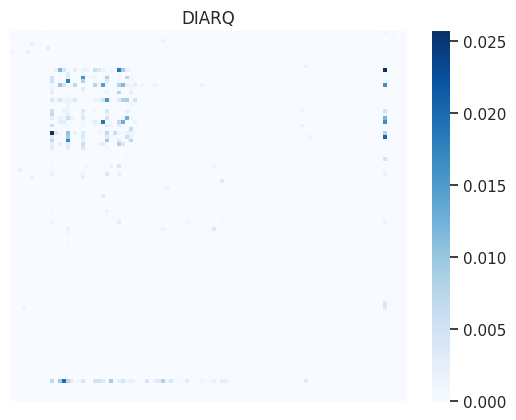

prob_sum = 0.999999999999995


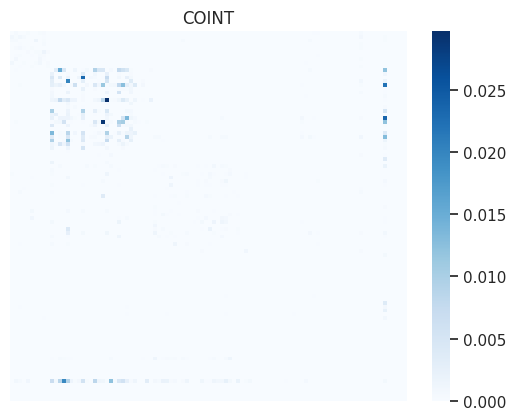

prob_sum = 0.9999999999999968


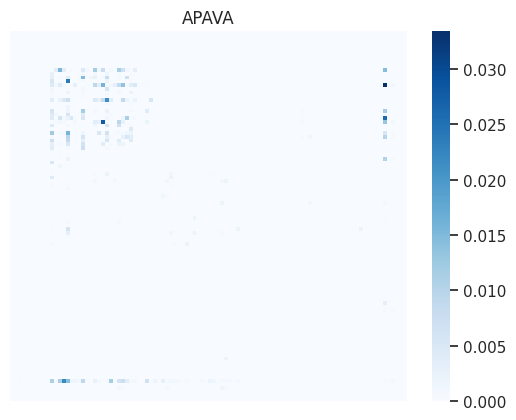

prob_sum = 0.9999999999999974


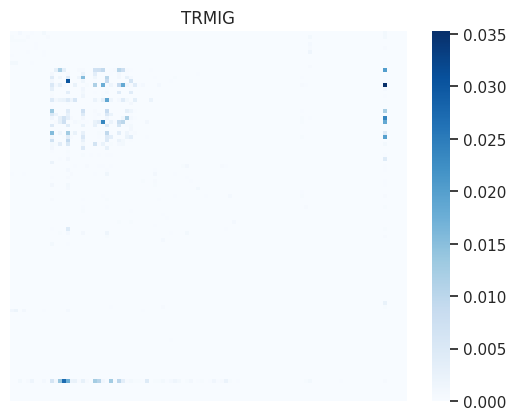

prob_sum = 1.000000000000005


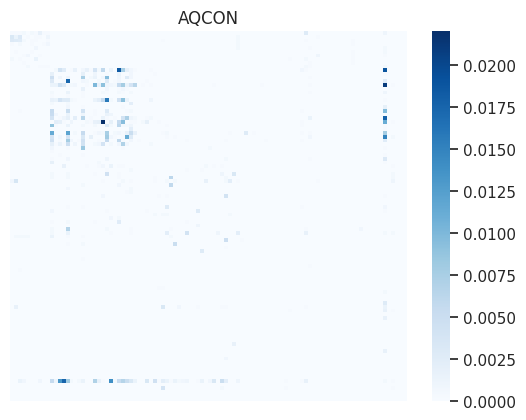

prob_sum = 0.9999999999999963


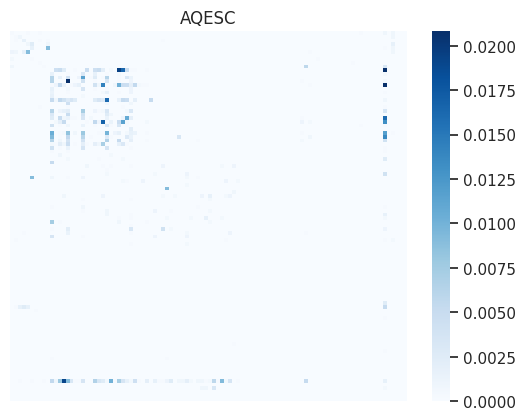

prob_sum = 0.9999999999999968


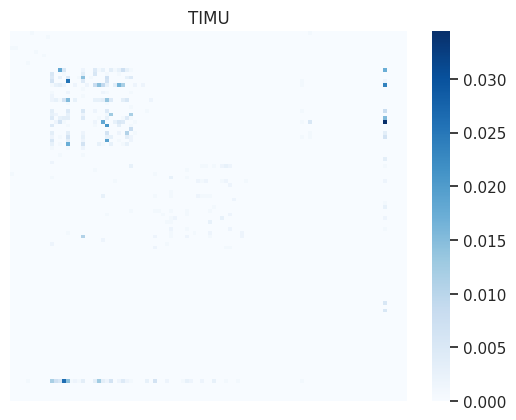

prob_sum = 0.9999999999999964


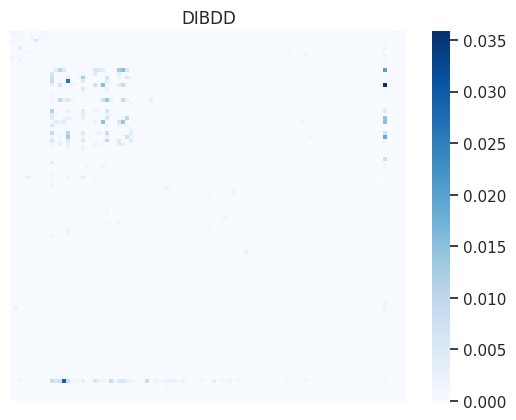

prob_sum = 1.0000000000000067


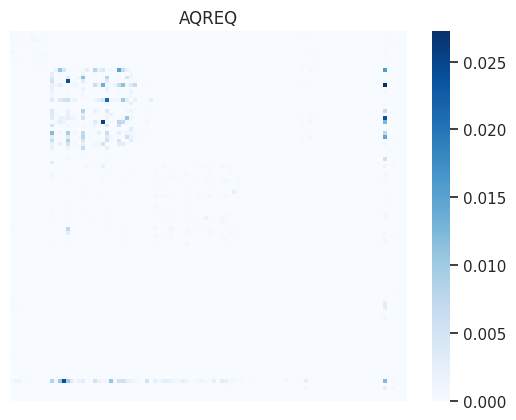

prob_sum = 1.000000000000002


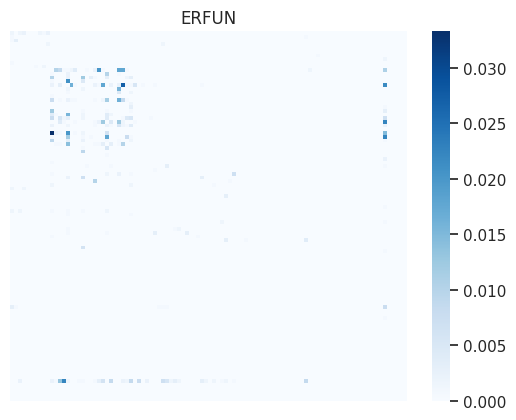

prob_sum = 0.9999999999999987


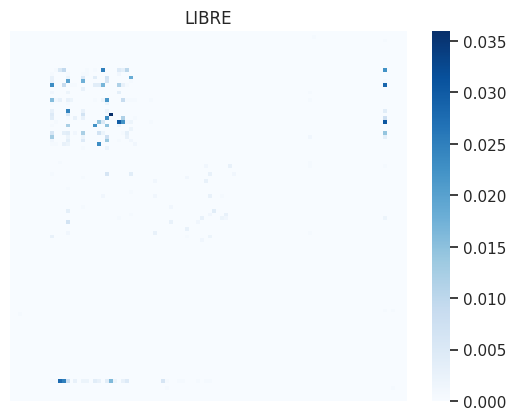

prob_sum = 1.0000000000000022


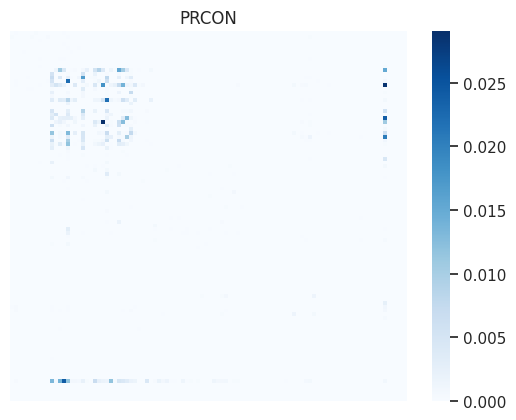

prob_sum = 0.9999999999999994


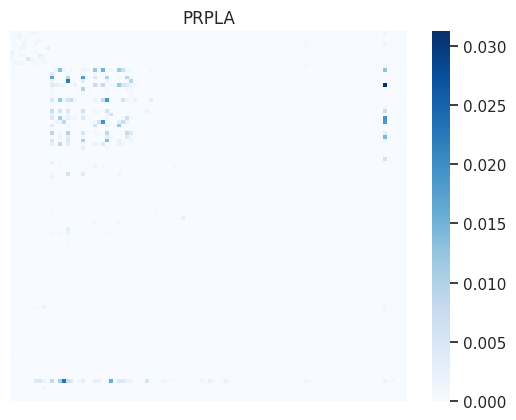

prob_sum = 1.0000000000000004


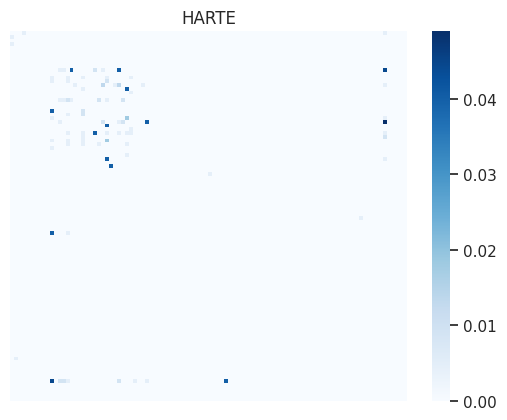

prob_sum = 0.9999999999999989


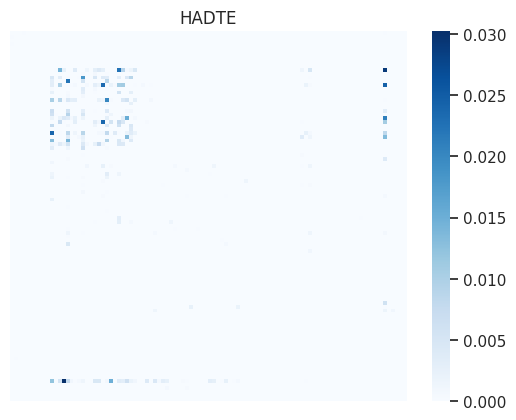

prob_sum = 0.9999999999999972


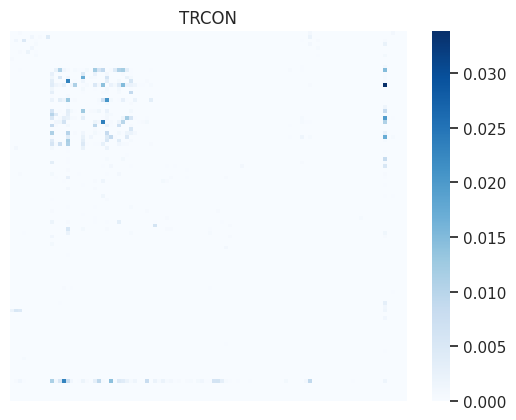

prob_sum = 1.000000000000003


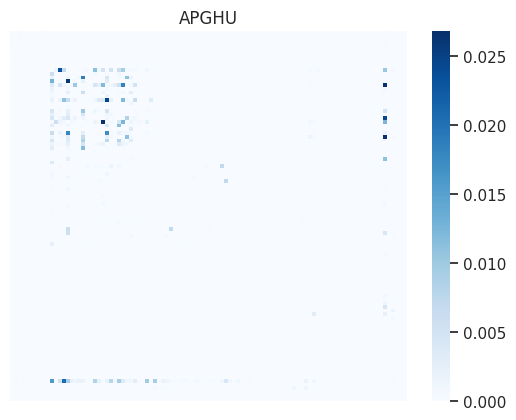

prob_sum = 0.9999999999999981


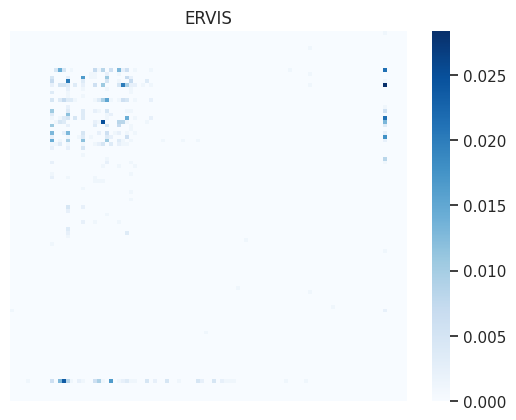

prob_sum = 0.9999999999999976


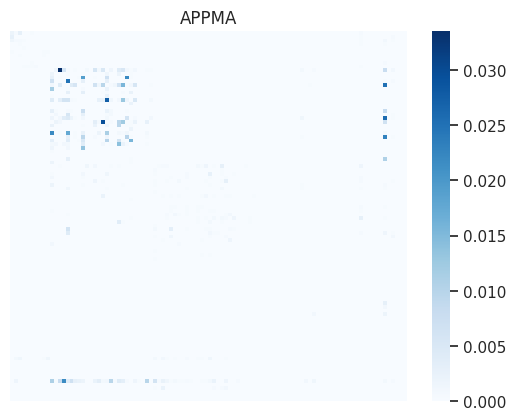

prob_sum = 1.0


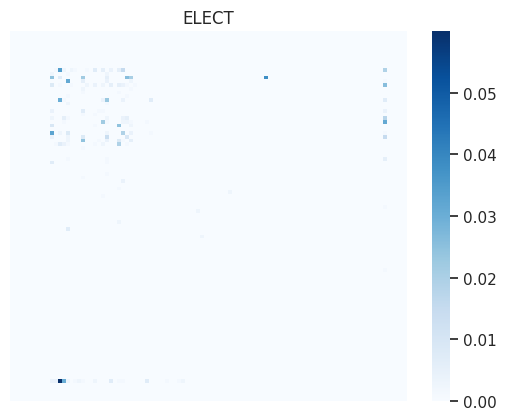

prob_sum = 0.9999999999999979


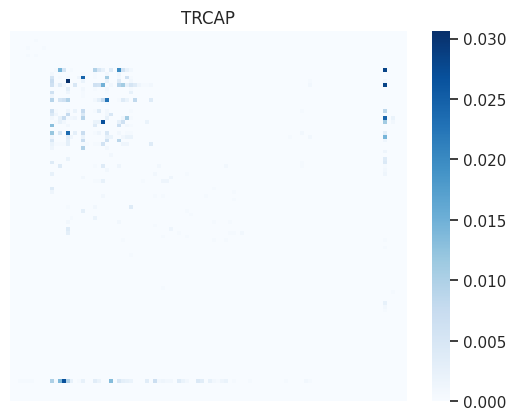

prob_sum = 1.0000000000000009


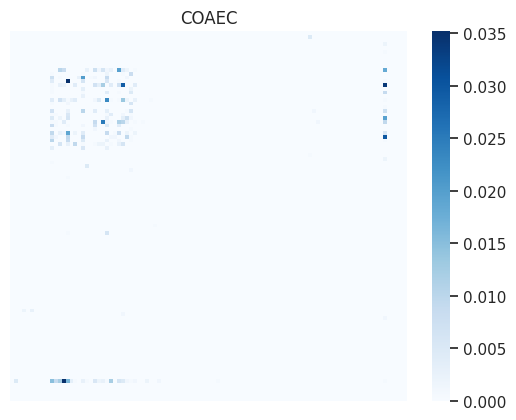

prob_sum = 0.9999999999999991


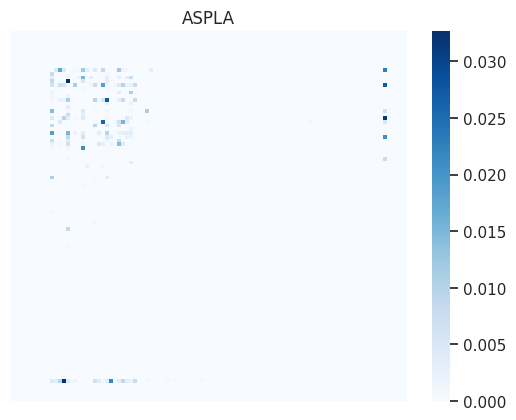

prob_sum = 1.0000000000000009


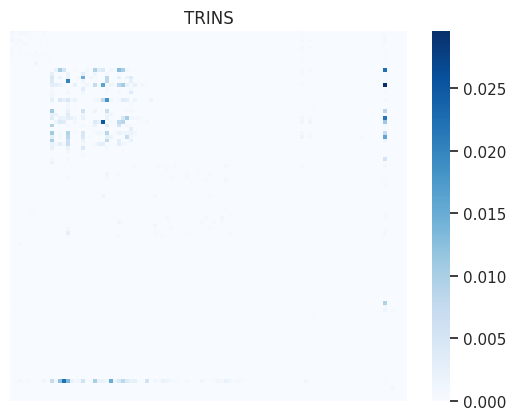

prob_sum = 1.0000000000000018


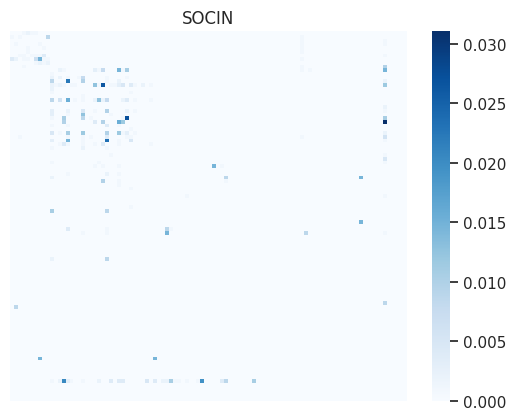

prob_sum = 1.0


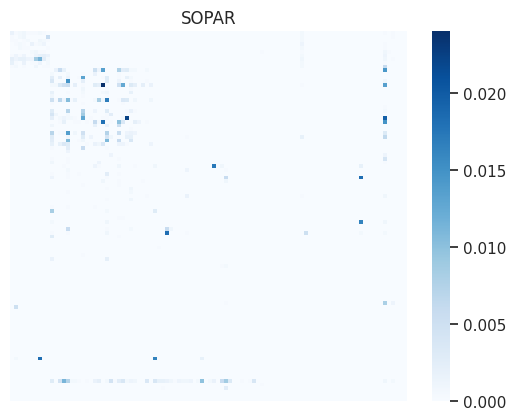

prob_sum = 1.0000000000000002


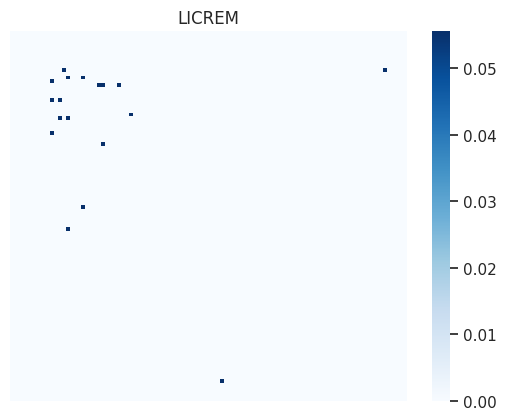

prob_sum = 1.0000000000000009


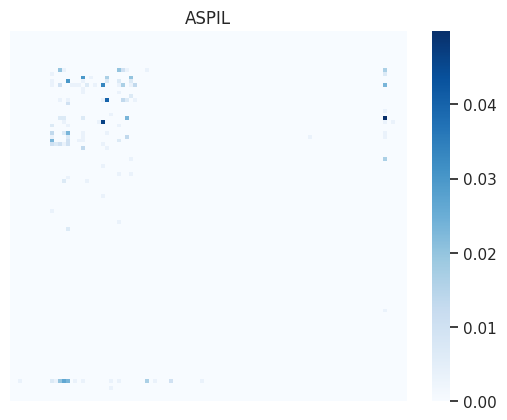

prob_sum = 1.0000000000000018


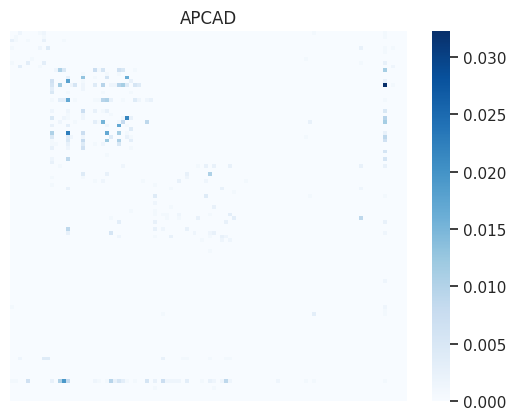

prob_sum = 1.0000000000000036


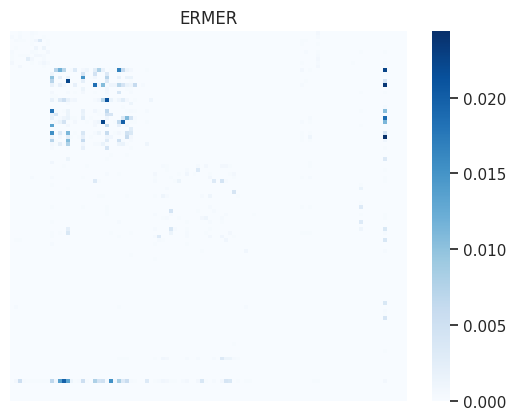

prob_sum = 1.000000000000001


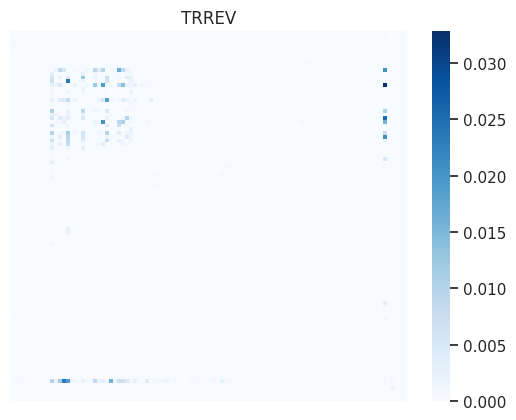

prob_sum = 1.0000000000000007


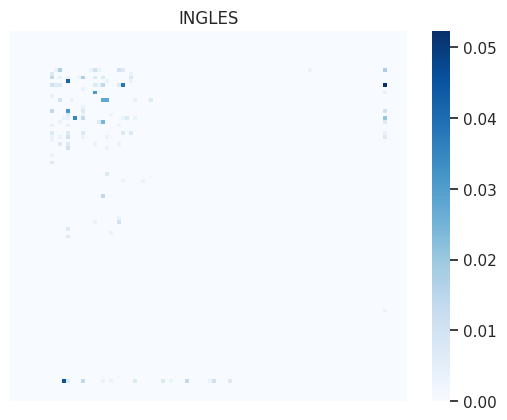

prob_sum = 1.0000000000000022


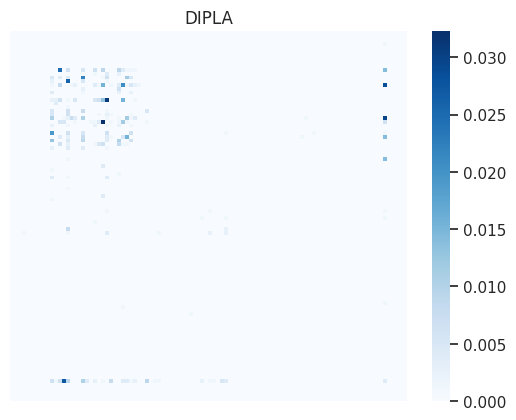

prob_sum = 1.0000000000000002


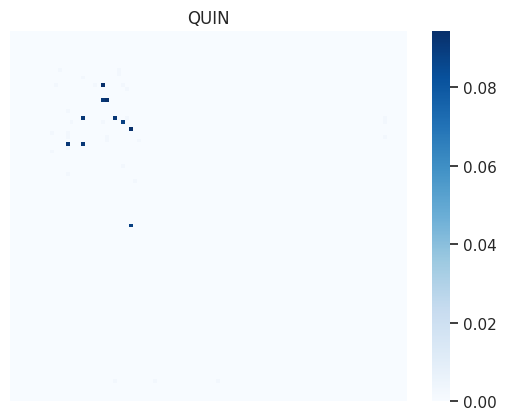

prob_sum = 0.9999999999999968


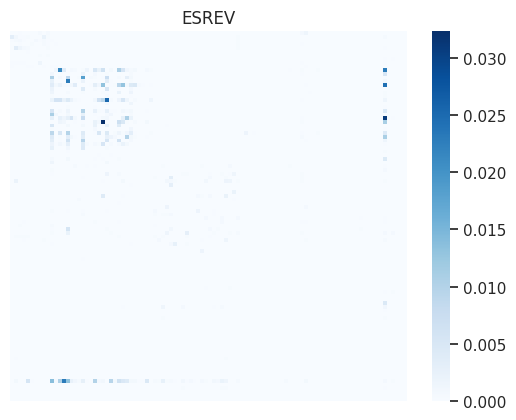

prob_sum = 1.0000000000000022


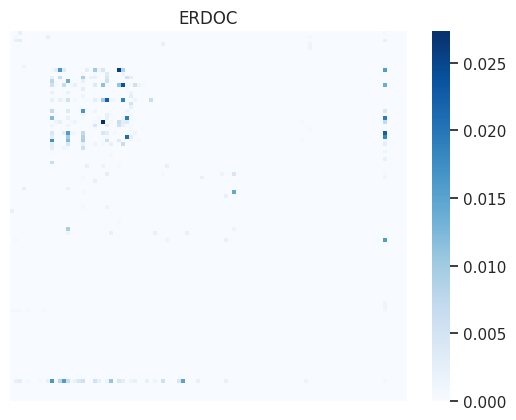

prob_sum = 1.0000000000000004


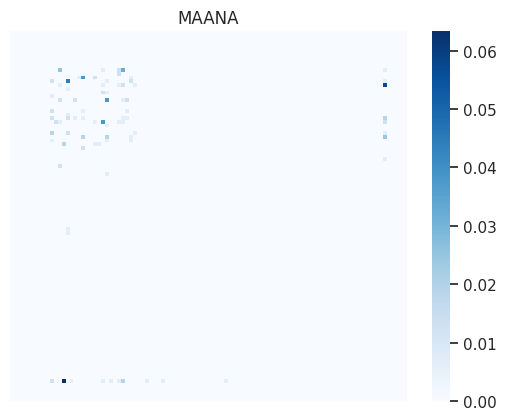

prob_sum = 1.0000000000000004


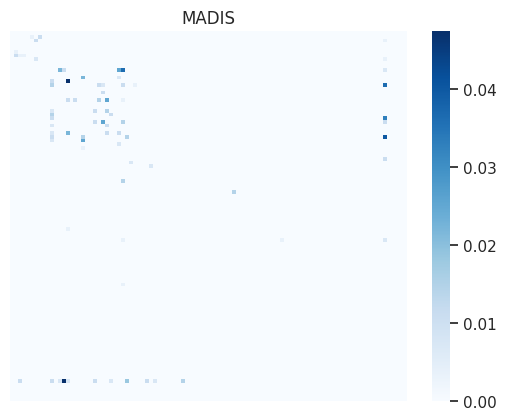

prob_sum = 0.9999999999999999


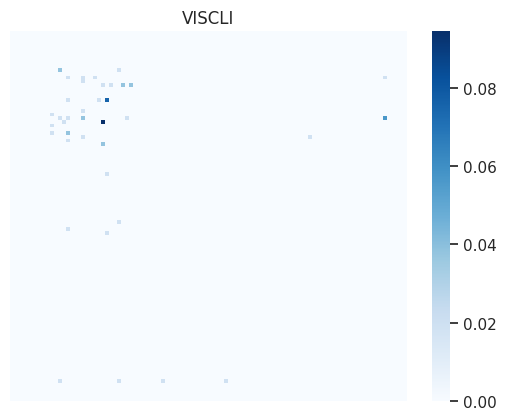

prob_sum = 0.9999999999999999


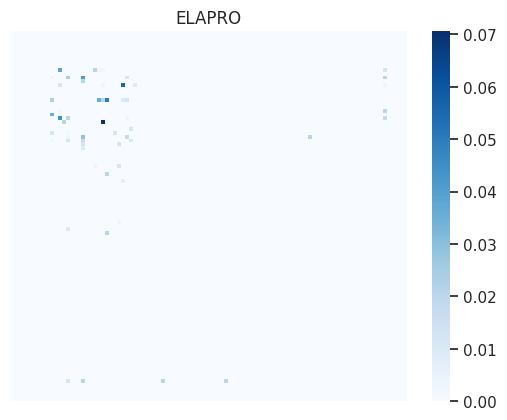

prob_sum = 1.0000000000000038


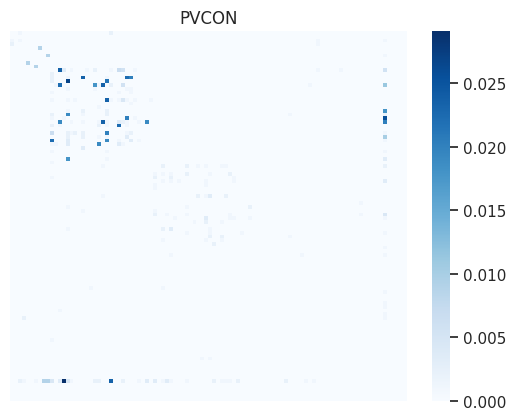

prob_sum = 1.0000000000000004


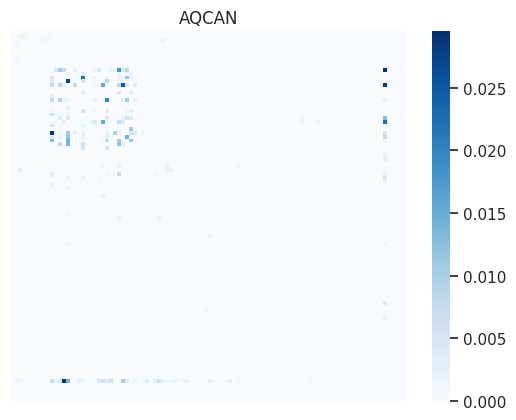

prob_sum = 0.9999999999999958


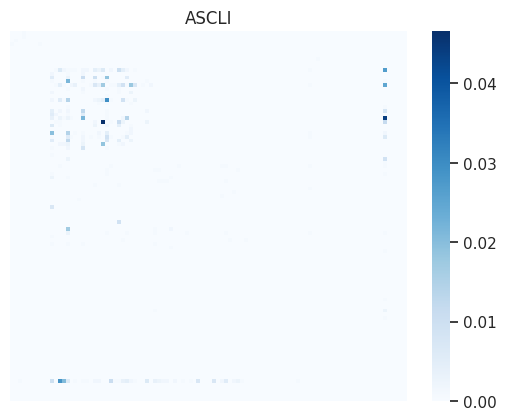

prob_sum = 1.0000000000000002


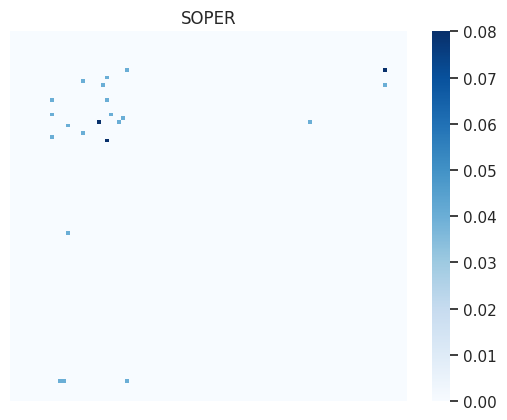

prob_sum = 0.9999999999999999


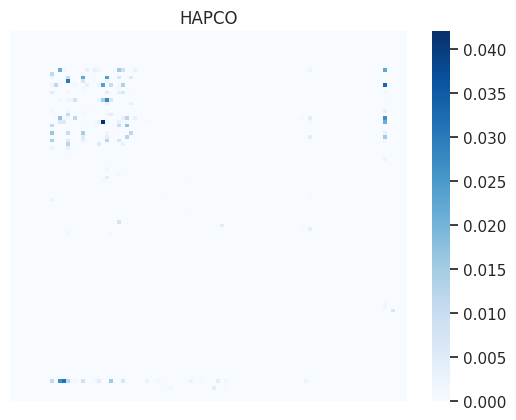

prob_sum = 1.000000000000004


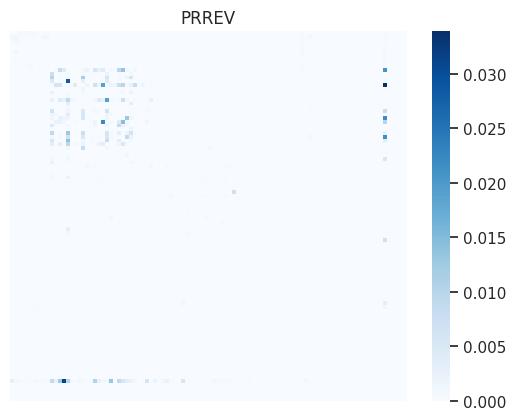

prob_sum = 0.9999999999999993


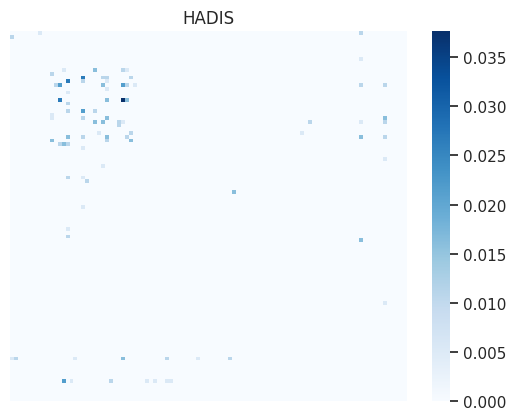

prob_sum = 0.9999999999999996


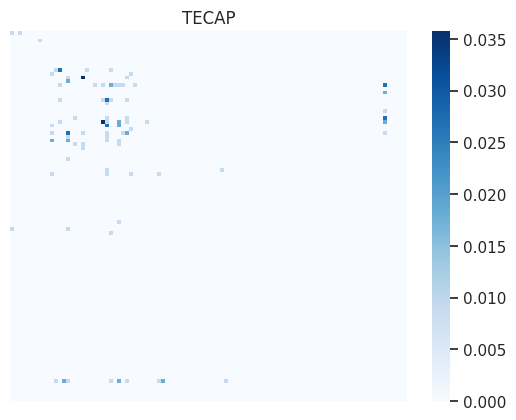

prob_sum = 0.9999999999999979


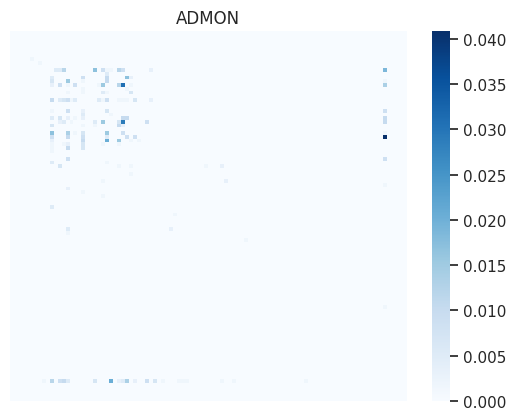

prob_sum = 1.0000000000000002


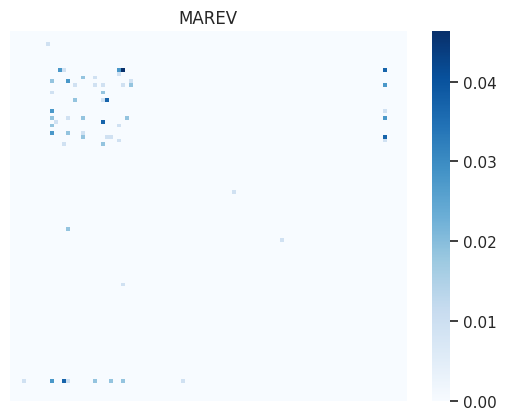

prob_sum = 0.9999999999999986


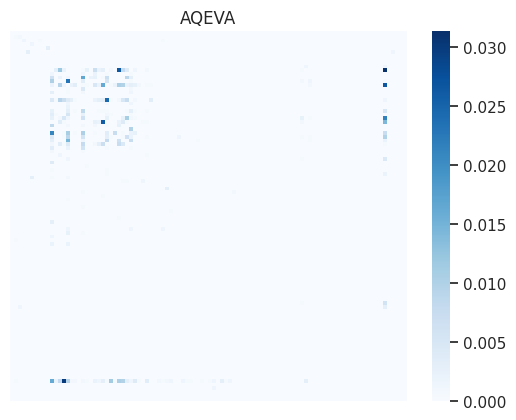

prob_sum = 1.0000000000000018


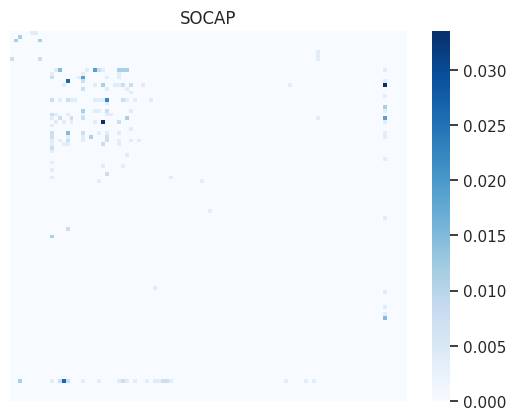

prob_sum = 1.0000000000000022


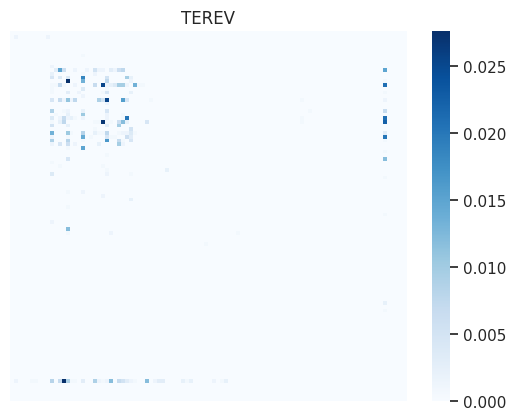

prob_sum = 1.0000000000000007


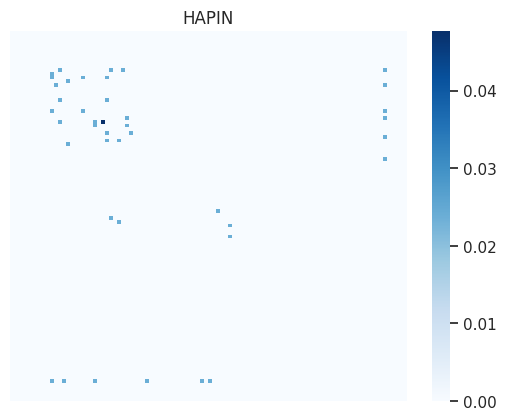

prob_sum = 0.9999999999999992


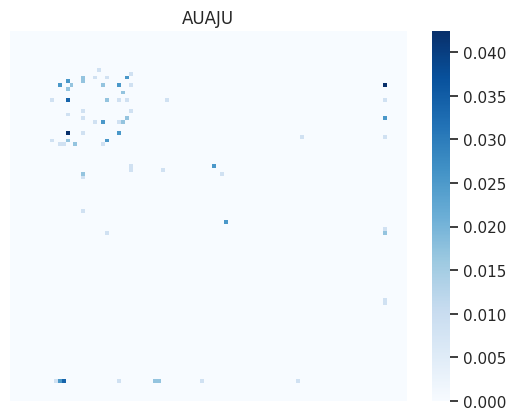

prob_sum = 1.0


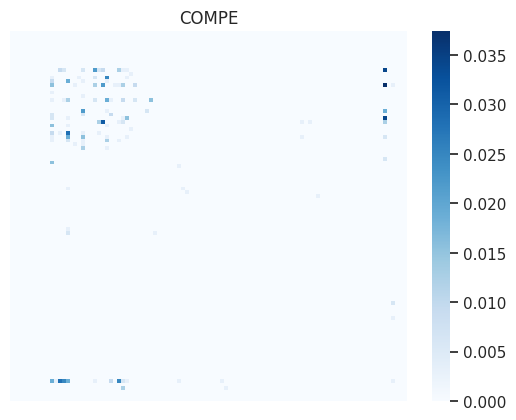

prob_sum = 1.0


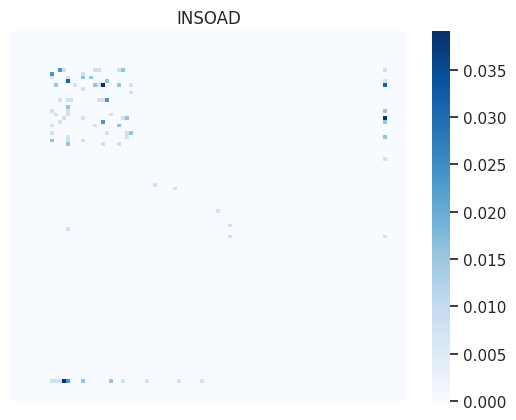

prob_sum = 0.9999999999999996


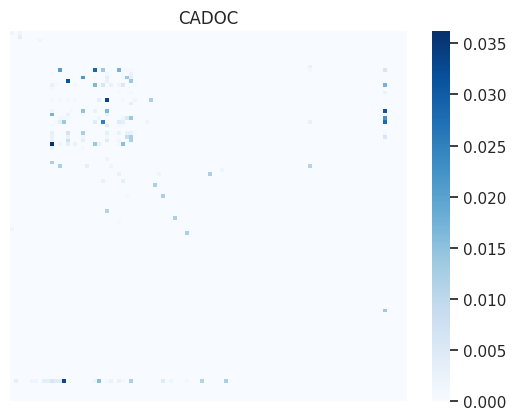

prob_sum = 1.0000000000000007


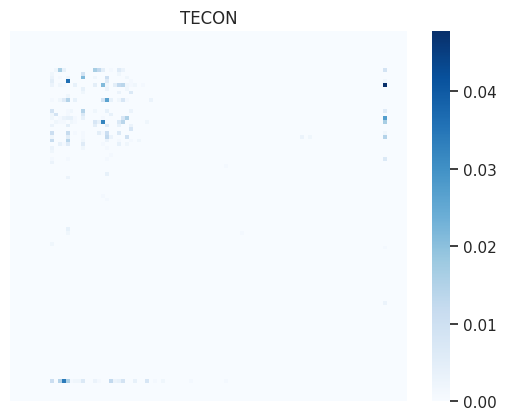

prob_sum = 1.0000000000000018


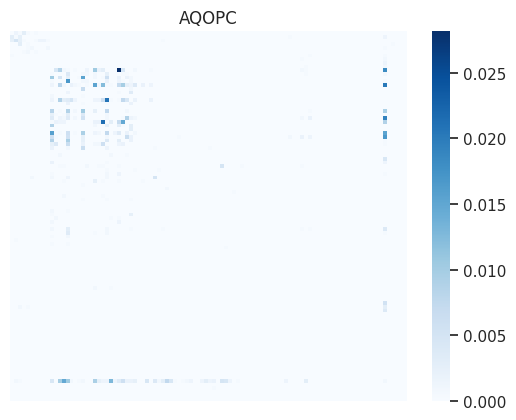

prob_sum = 1.0000000000000007


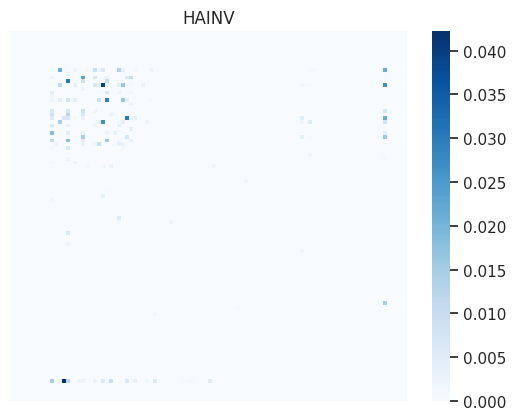

prob_sum = 0.9999999999999989


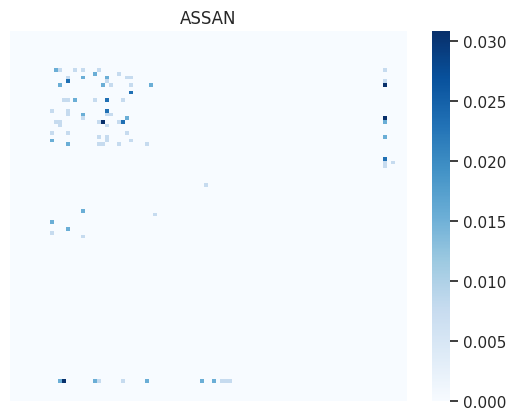

prob_sum = 1.0000000000000016


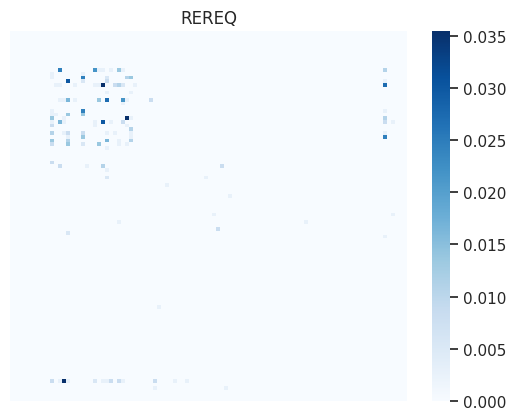

prob_sum = 0.9999999999999989


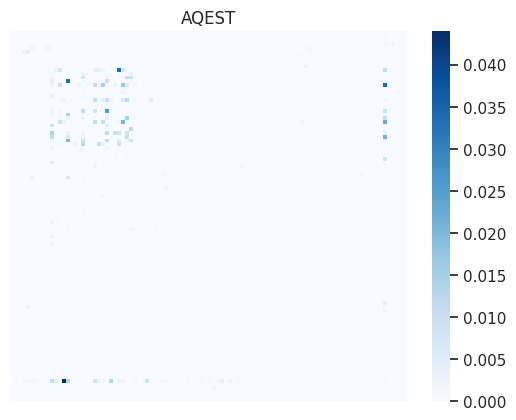

prob_sum = 1.0000000000000002


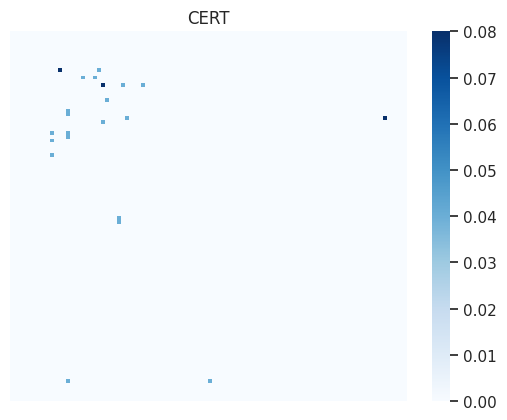

prob_sum = 1.0000000000000004


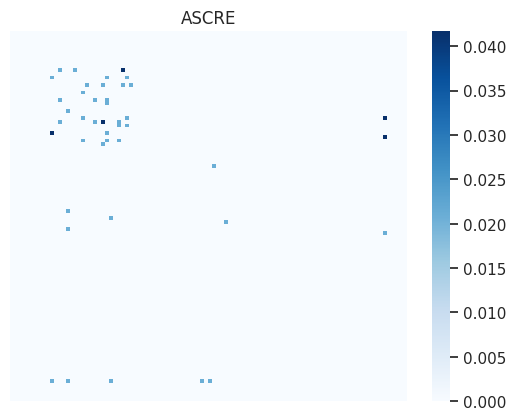

prob_sum = 0.9999999999999967


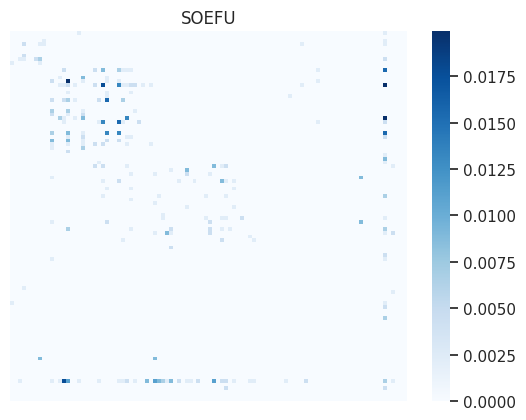

prob_sum = 0.9999999999999996


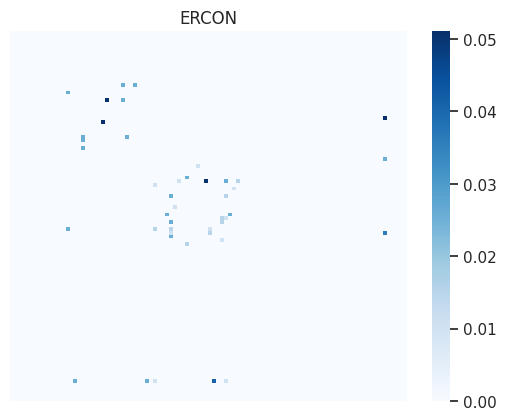

prob_sum = 1.0000000000000004


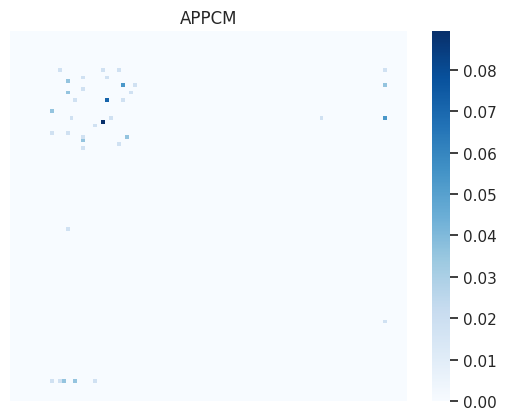

prob_sum = 0.9999999999999986


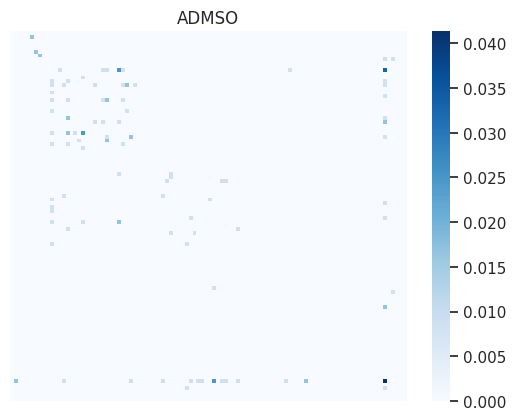

prob_sum = 1.0000000000000004


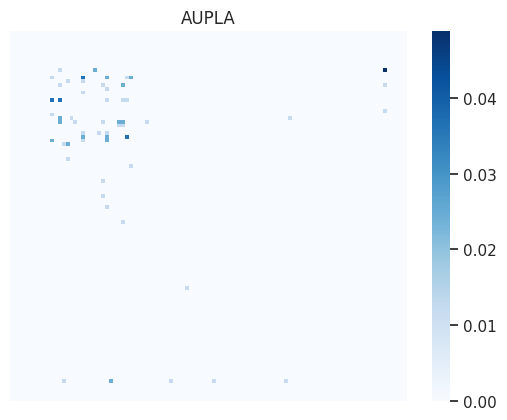

prob_sum = 1.0000000000000007


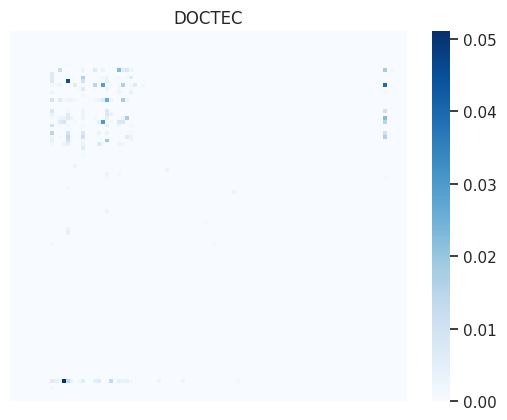

prob_sum = 1.0000000000000009


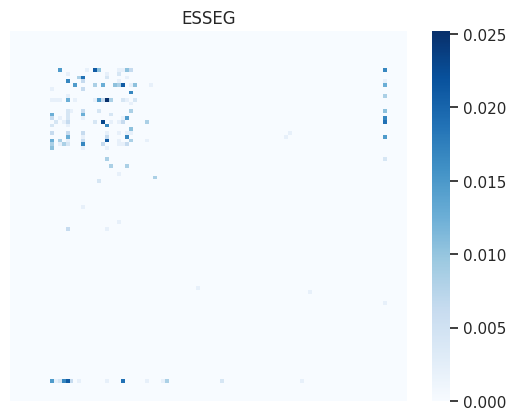

/tmp/ipykernel_4443/4045290717.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return character_count/total_characters
/home/jrsalgado/projects/prob_and_statistics/hw4_ares/.venv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/jrsalgado/projects/prob_and_statistics/hw4_ares/.venv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


prob_sum = nan


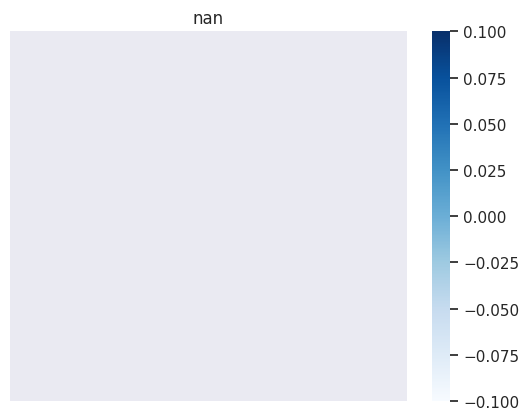

prob_sum = 1.0


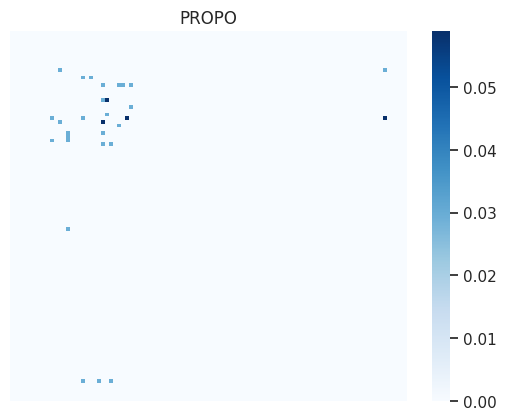

prob_sum = 1.0000000000000013


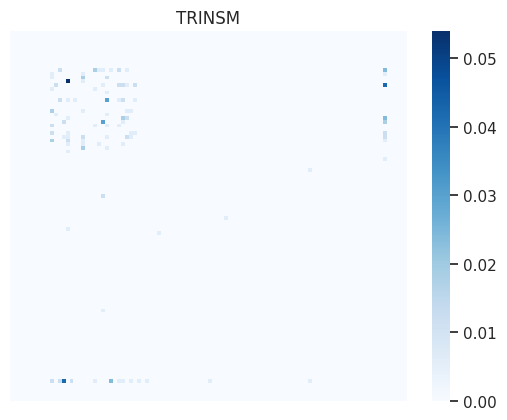

prob_sum = 1.0000000000000004


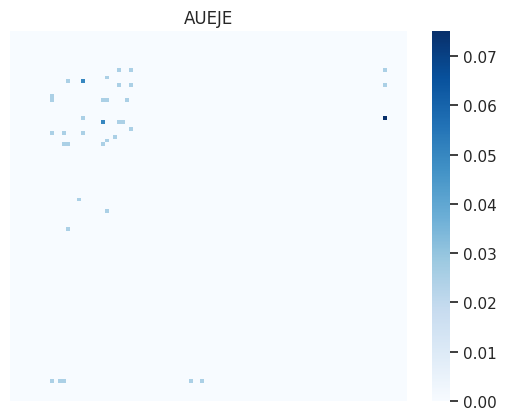

prob_sum = 1.000000000000001


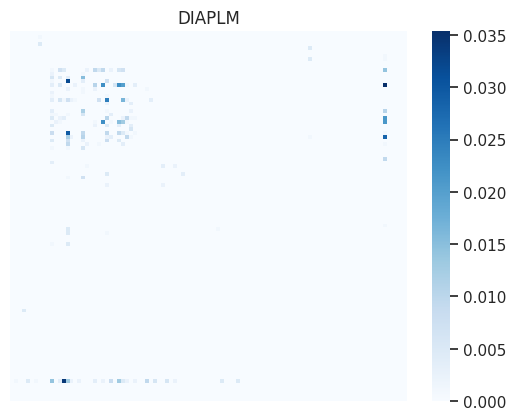

prob_sum = 1.0000000000000007


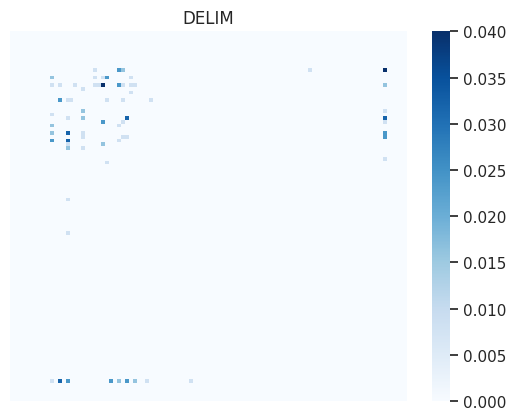

prob_sum = 0.9999999999999999


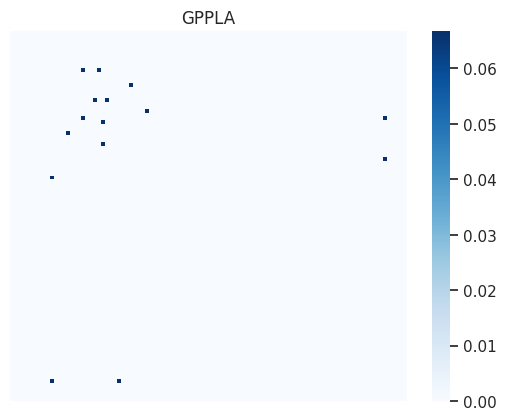

prob_sum = 0.9999999999999983


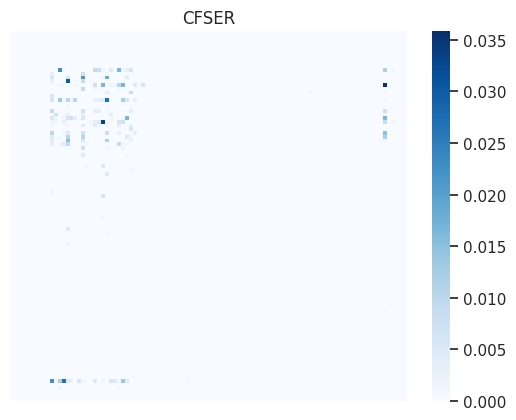

prob_sum = 0.9999999999999993


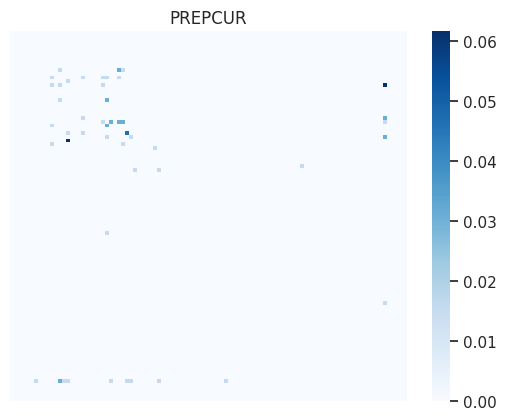

prob_sum = 1.0000000000000004


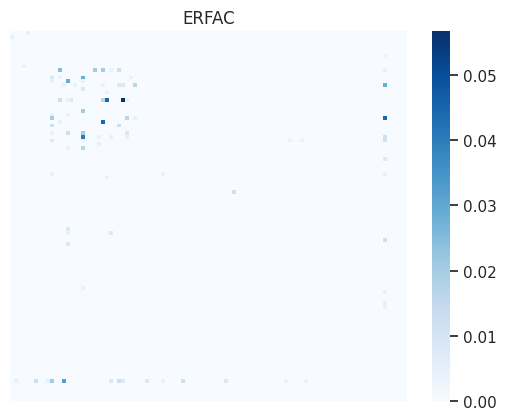

prob_sum = 1.0


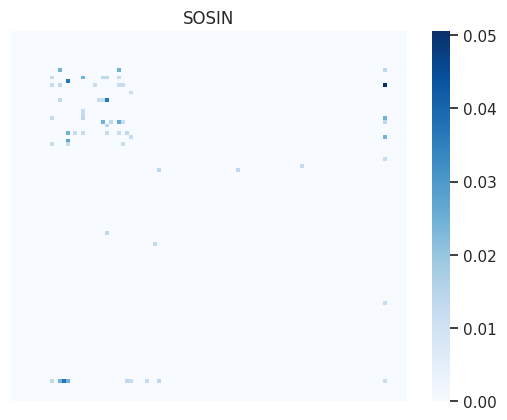

prob_sum = 1.0000000000000004


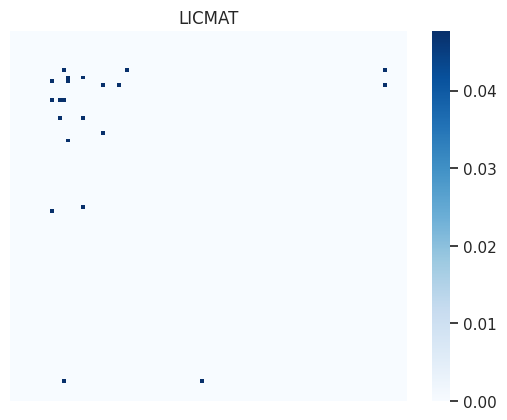

prob_sum = 0.9999999999999996


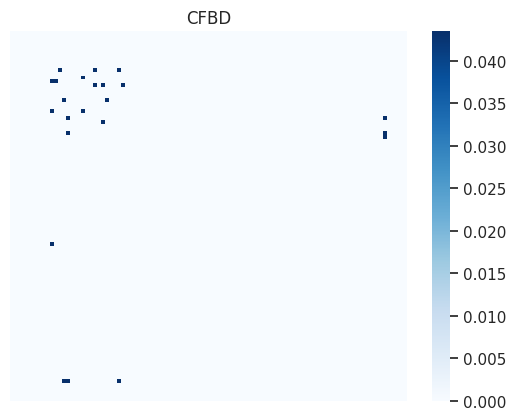

prob_sum = 0.9999999999999999


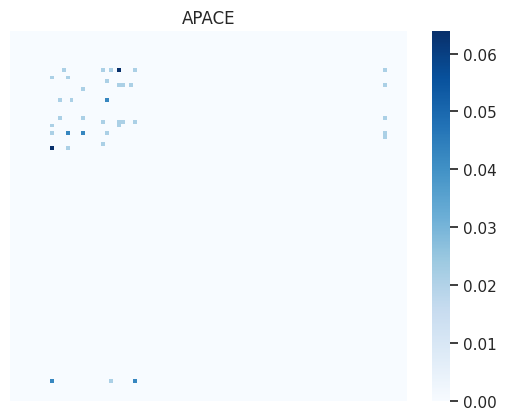

prob_sum = 0.9999999999999992


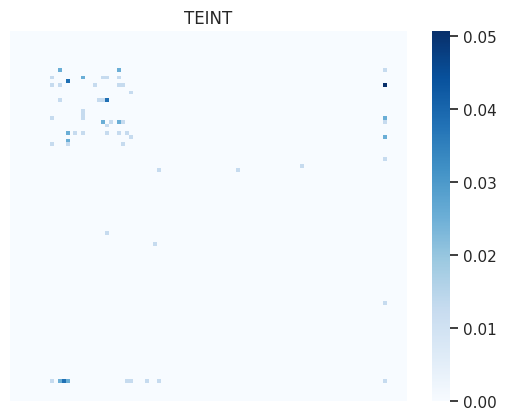

prob_sum = 0.9999999999999999


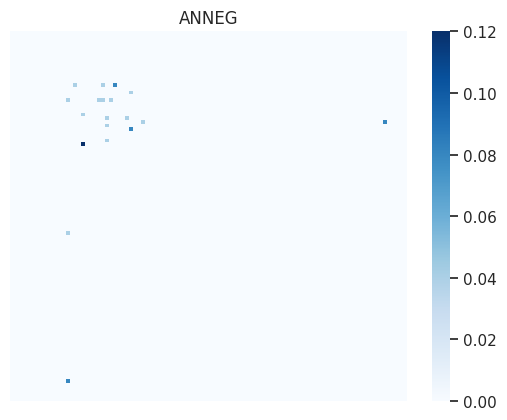

prob_sum = 0.9999999999999997


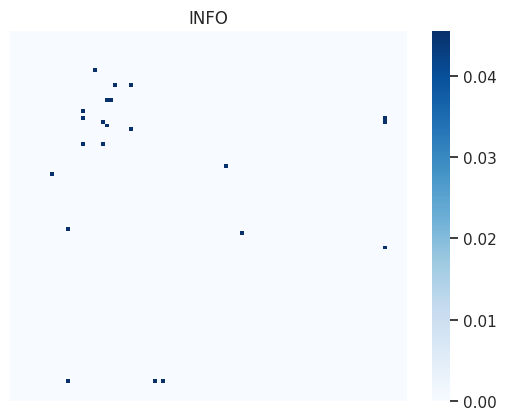

prob_sum = 1.0000000000000009


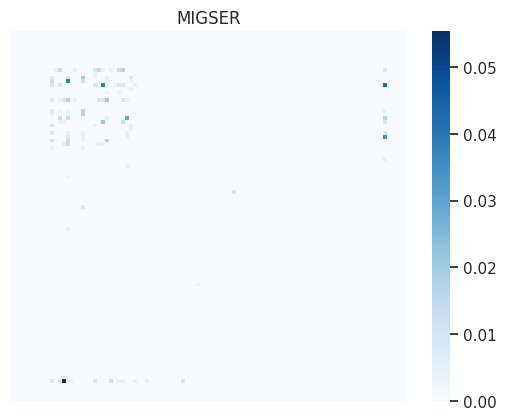

prob_sum = 0.9999999999999999


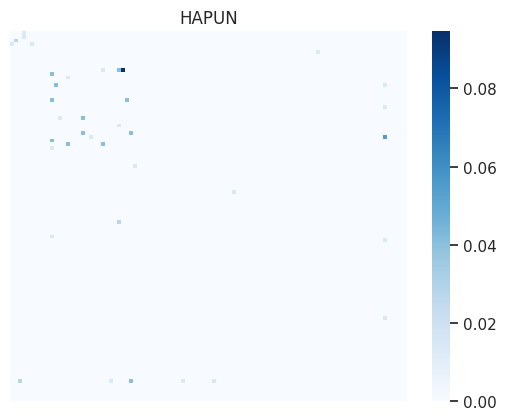

prob_sum = 1.0


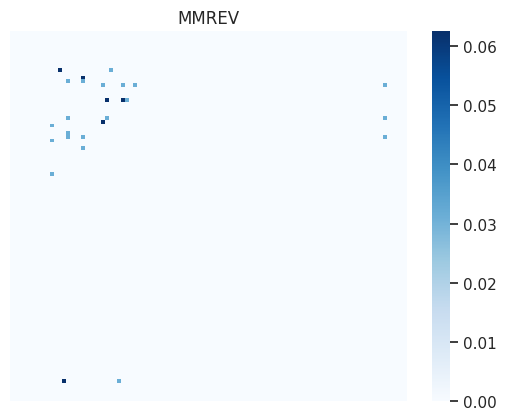

prob_sum = 1.0


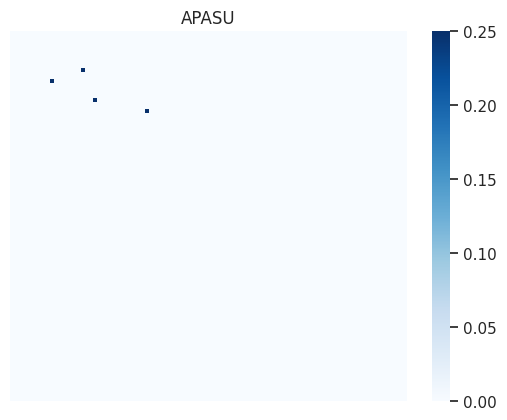

In [174]:

all_stages = get_all_stages(data)
for stage in all_stages:
    stage_descriptions = get_stage_descriptions(data,stage)
    STAGE_dist = get_filled_biagram(stage_descriptions)
    STAGE_dist = get_joint_probabilities(STAGE_dist)
    graph_matrix_heatmap(STAGE_dist, title=stage)

# Model Creation for Duration Prediction

## Model Implementation for duration prediction